# 0.0. Impor Libraries

In [ ]:
import os
import shutil
import torch
import torchvision
import kagglehub
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from PIL import Image

import torchvision.transforms.functional as F
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('fivethirtyeight')

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 1.0. Defining Auxiliar Code

In [ ]:
class VehicleDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)

    if image.shape[-1] == 4:
        image = image[:, :, :3]

    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    image = torchvision.transforms.functional.to_pil_image(image)
    image = torchvision.transforms.functional.to_tensor(image)

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [ ]:
def calculate_mean_std(data_loader):
    total_sum = torch.zeros(3)
    total_sum_sq = torch.zeros(3)
    total_pixels = 0

    for images, _ in data_loader:
        images = images.to("cpu")

        pixels = images.view(images.size(0), images.size(1), -1)

        total_sum += pixels.sum(dim=(0, 2))
        total_sum_sq += (pixels ** 2).sum(dim=(0, 2))

        total_pixels += pixels.size(0) * pixels.size(2)

    mean = total_sum / total_pixels

    std = torch.sqrt(total_sum_sq / total_pixels - mean ** 2)

    return mean, std

In [ ]:
def split_dataset(dataset, test_size=0.2, random_seed=42):
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_seed)

    return train_indices, test_indices

In [ ]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device
):
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_logits = model(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits, y.type(torch.float32))
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

In [ ]:
def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device
):
    test_loss, test_acc = 0, 0

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_logits = model(X).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss += loss_fn(test_logits, y.type(torch.float32))
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    return test_loss, test_acc

In [ ]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    if y_pred.dim() == 0:
        acc = (correct / 1) * 100
    else:
        acc = (correct / len(y_pred)) * 100

    return acc

In [ ]:
def register_hooks(model):
    feature_maps = {}
    hooks = []

    for idx, layer in enumerate(model):
        if isinstance(layer, nn.Conv2d):
            handle = layer.register_forward_hook(
                lambda _, __, output, layer_idx=idx: feature_maps.update({f"conv_{layer_idx}": output})
            )

            hooks.append(handle)

    return hooks, feature_maps

In [ ]:
def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()

    hooks.clear()

In [ ]:
def load_and_flatten_images(dataset, root_dir, img_size=(64, 64)):
    flattened_images = []
    labels = []

    for _, row in dataset.iterrows():
        img_path = os.path.join(root_dir, row['filename'])
        img = Image.open(img_path).convert('RGB').resize(img_size)
        img_array = np.array(img).flatten()
        flattened_images.append(img_array)
        labels.append(row['label'])

    return np.array(flattened_images), np.array(labels)

In [ ]:
def plot_tsne(tsne_features, labels, class_labels=["Car", "Bike"]):
    plt.figure(figsize=(14, 10))

    scatter = plt.scatter(
        tsne_features[:, 0], tsne_features[:, 1],
        c=labels,
        s=70,
        cmap='viridis',
        alpha=0.85
    )

    plt.xlabel("")
    plt.ylabel("")

    handles = [
        mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=label)
        for i, label in enumerate(class_labels)
    ]

    plt.legend(
        handles=handles,
        fontsize=12,
        loc="upper right",
        frameon=True,
        shadow=True,
        borderpad=1.2
    )

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

## 2.0. Data Acquisition

In [ ]:
path = kagglehub.dataset_download("utkarshsaxenadn/car-vs-bike-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 103M/103M [00:01<00:00, 79.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset/versions/1


In [ ]:
os.listdir(path)

['Car-Bike-Dataset']

In [ ]:
label_dict = {}

for index, dir in enumerate(os.listdir(path + "/Car-Bike-Dataset")):
  label_dict[dir] = index

label_dict

{'Car': 0, 'Bike': 1}

In [ ]:
if(not os.path.exists("Images")):
  os.mkdir("Images")

data = {
    "filename": [],
    "label": []
}

for dir in os.listdir(path + "/Car-Bike-Dataset"):
  for img in os.listdir(path + "/Car-Bike-Dataset/" + dir):
    shutil.copyfile(path + "/Car-Bike-Dataset/" + dir + "/" + img, "./Images/" + img)
    data["filename"].append(img)
    data["label"].append(label_dict[dir])

vehicle_dataset = pd.DataFrame(data)
vehicle_dataset.to_csv("vehicle_dataset.csv", index=False)

In [ ]:
vehicle_dataset

,filename,label
0,Car (586).jpeg,0
1,Car (103).jpeg,0
2,Car (107).jpeg,0
3,Car (239).jpeg,0
4,Car (29).jpeg,0
...,...,...
3995,images (140).jpeg,1
3996,Bike (791).jpeg,1
3997,Bike (799).jpeg,1
3998,image (28).jpeg,1


In [ ]:
initial_transform = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
dataset = VehicleDataset(
    csv_file="vehicle_dataset.csv",
    root_dir="Images",
    transform=initial_transform
)

In [ ]:
train_indices, test_indices = split_dataset(dataset)

In [ ]:
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
train_mean, train_std = calculate_mean_std(train_loader)

In [ ]:
final_transform = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

In [ ]:
train_dataset.dataset.transform = final_transform
test_dataset.dataset.transform = final_transform

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3.0. Model Acquisition

In [ ]:
model = torchvision.models.vgg16(pretrained=True)

model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 175MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 3.1. Model to Fine Tuning

In [ ]:
model_fine_tuning = model

in_features = model_fine_tuning.classifier[6].in_features

model_fine_tuning.classifier[6] = nn.Linear(in_features=in_features, out_features=1)

model_fine_tuning

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 3.2.Model to Feature Extraction

In [ ]:
model_feature_extraction = model

model_feature_extraction = nn.Sequential(*list(model_feature_extraction.features.children()))

model_feature_extraction

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Models to Device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [ ]:
model_fine_tuning = model_fine_tuning.to(device)
model_feature_extraction = model_feature_extraction.to(device)

# 4.0. Fine Tuning

In [ ]:
for param in model_fine_tuning.parameters():
    param.requires_grad = False

for param in model_fine_tuning.classifier[6].parameters():
    param.requires_grad = True

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_fine_tuning.parameters(), lr=0.001)

In [ ]:
epochs = 5

train_loss_list, train_acc_list = [], []
test_loss_list, test_acc_list = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch}\n-------------------------------------------------------------------------")
    train_loss, train_acc = train_step(
        model=model_fine_tuning,
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    test_loss, test_acc = test_step(
        data_loader=test_loader,
        model=model_fine_tuning,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    print("-------------------------------------------------------------------------\n")


Epoch 0
-------------------------------------------------------------------------
Train loss: 0.07649 | Train accuracy: 97.31%
Test loss: 0.03170 | Test accuracy: 99.00%
-------------------------------------------------------------------------

Epoch 1
-------------------------------------------------------------------------
Train loss: 0.02019 | Train accuracy: 99.59%
Test loss: 0.02953 | Test accuracy: 99.00%
-------------------------------------------------------------------------

Epoch 2
-------------------------------------------------------------------------
Train loss: 0.01380 | Train accuracy: 99.78%
Test loss: 0.02848 | Test accuracy: 99.00%
-------------------------------------------------------------------------

Epoch 3
-------------------------------------------------------------------------
Train loss: 0.00971 | Train accuracy: 99.84%
Test loss: 0.02938 | Test accuracy: 99.00%
-------------------------------------------------------------------------

Epoch 4
------------

# 4.1. Plotting

In [ ]:
train_loss_list = [value.item() for value in train_loss_list]
test_loss_list = [value.item() for value in test_loss_list]

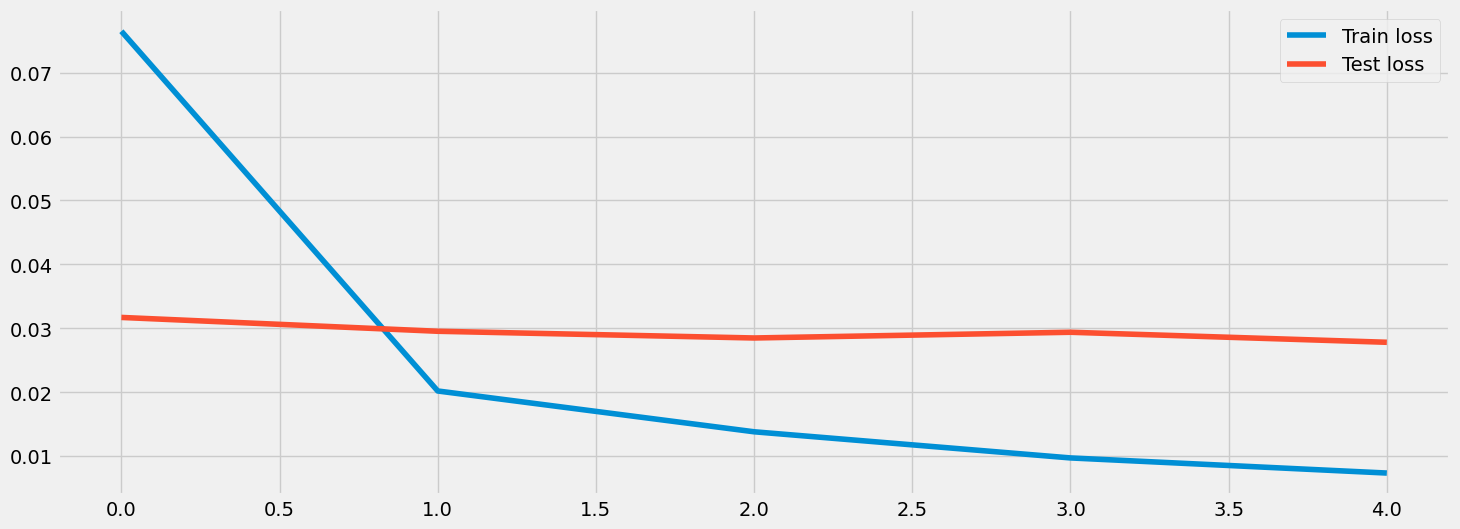

In [ ]:
plt.figure(figsize=(16, 6))

plt.plot(train_loss_list, label="Train loss")
plt.plot(test_loss_list, label="Test loss")

plt.legend()

plt.show()

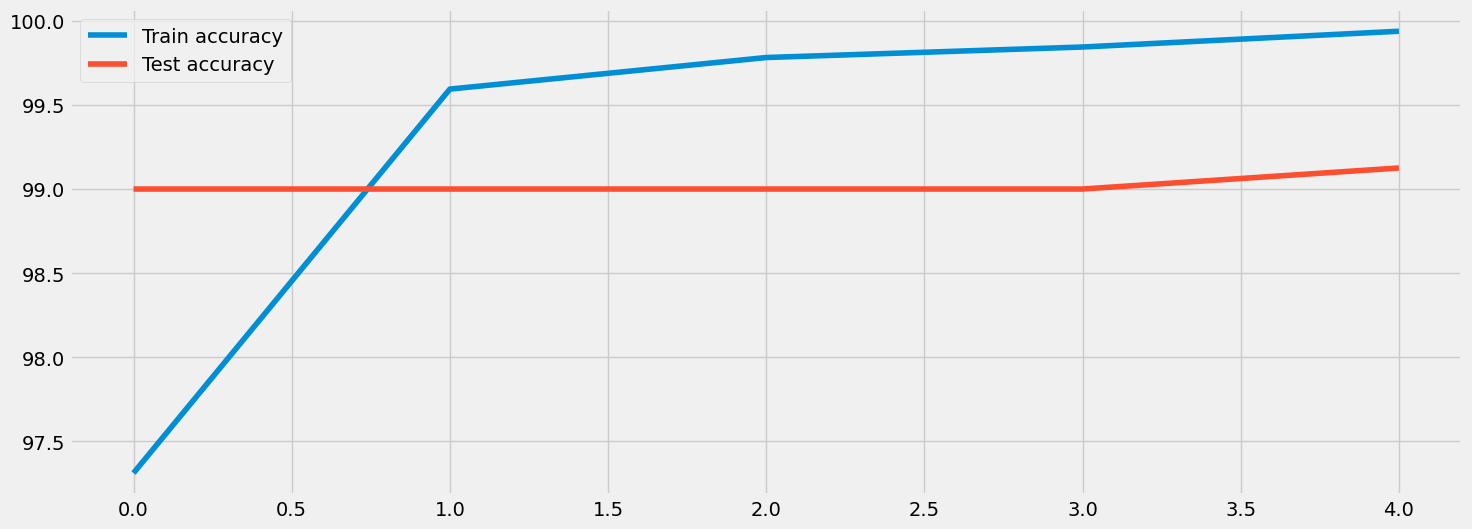

In [ ]:
plt.figure(figsize=(16, 6))

plt.plot(train_acc_list, label="Train accuracy")
plt.plot(test_acc_list, label="Test accuracy")

plt.legend()

plt.show()

# 5.0. Feature Extraction

In [ ]:
hooks, feature_maps = register_hooks(model_feature_extraction)

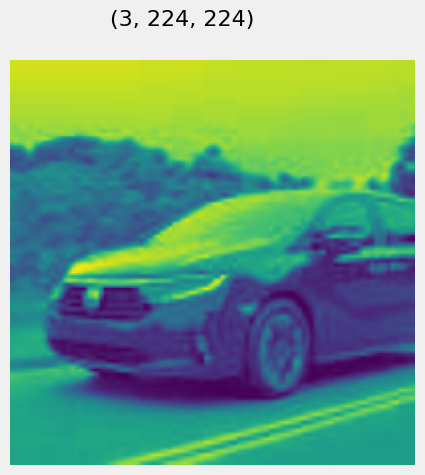

In [ ]:
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        _ = model_feature_extraction(images)

        fig, ax = plt.subplots(figsize=(20, 5))

        ax.imshow(images[0][0].cpu().numpy(), cmap="viridis")
        ax.axis("off")

        fig.suptitle(f"{images[0].cpu().numpy().shape}", fontsize=16)

        plt.show()
        break

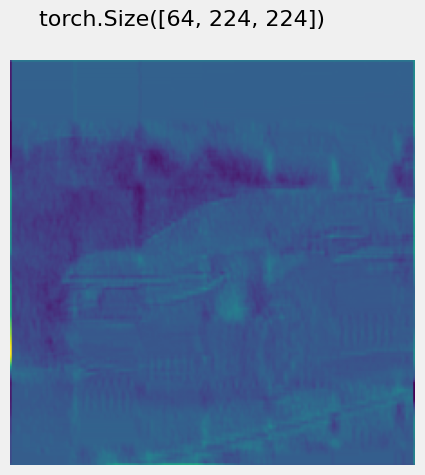

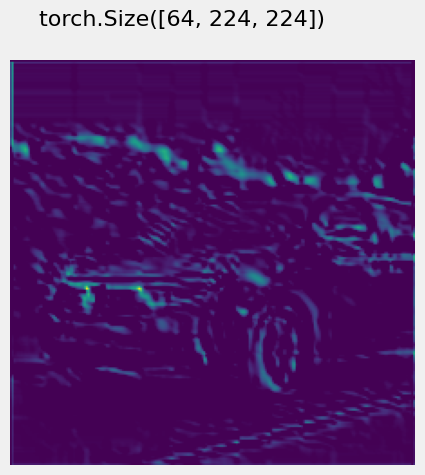

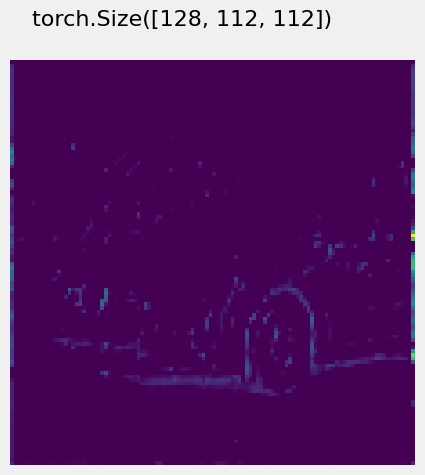

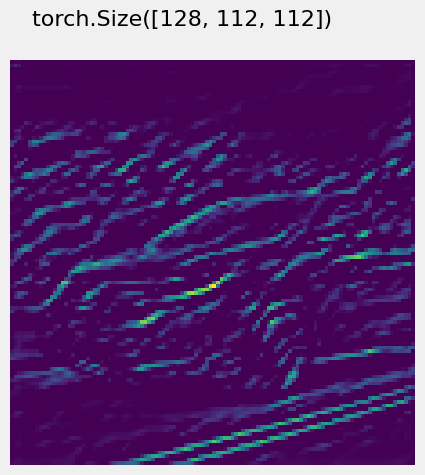

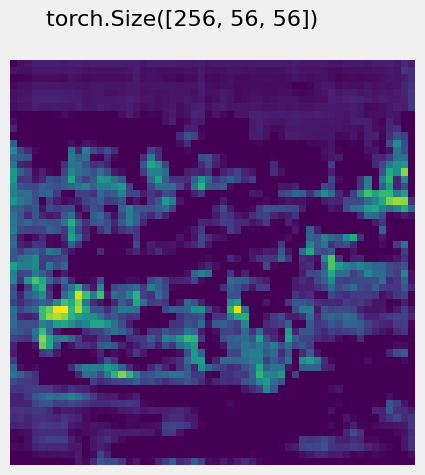

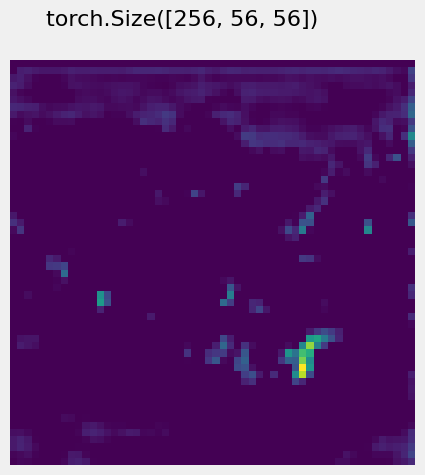

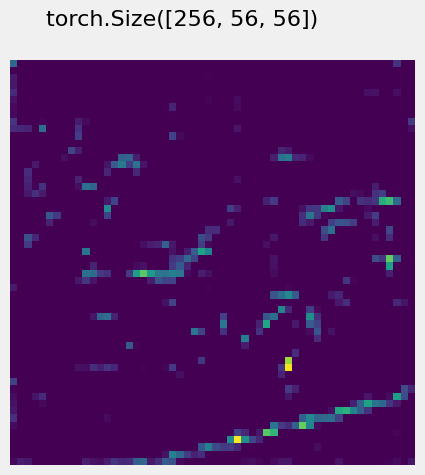

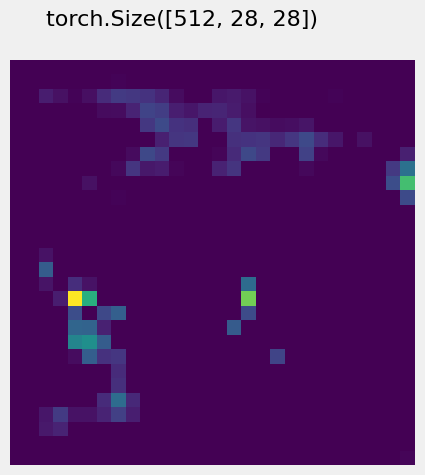

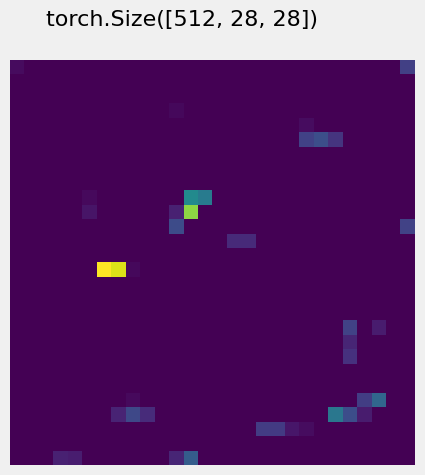

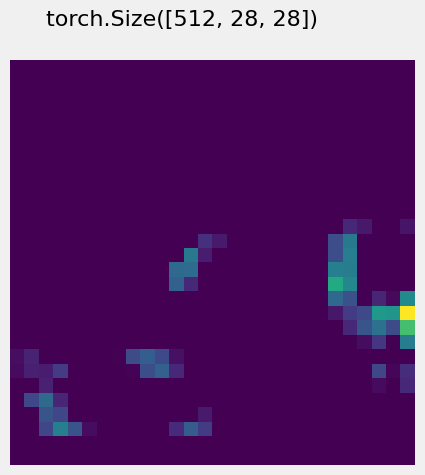

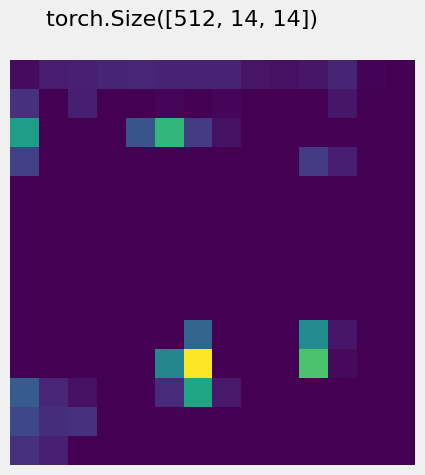

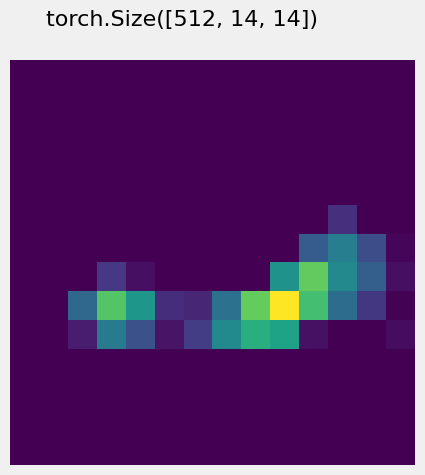

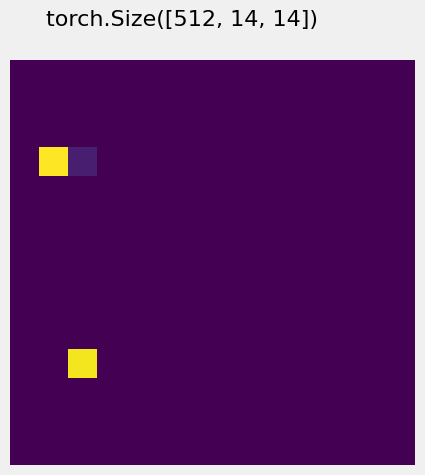

In [ ]:
for layer_name in list(feature_maps.keys()):
    features = feature_maps[layer_name][0]

    fig, ax = plt.subplots(figsize=(20, 5))

    ax.imshow(features[0].cpu().numpy(), cmap="viridis")
    ax.axis("off")

    fig.suptitle(f"{features.shape}", fontsize=16)
    plt.show()

In [ ]:
remove_hooks(hooks)

In [ ]:
dataset = pd.read_csv("vehicle_dataset.csv")

flattened_images, labels = load_and_flatten_images(dataset.iloc[test_indices], "Images", (256, 256))

pca_original = PCA(n_components=50, random_state=42)
pca_features_original = pca_original.fit_transform(flattened_images)

tsne_original = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features_original = tsne_original.fit_transform(pca_features_original)

In [ ]:
explained_variance = pca_original.explained_variance_ratio_

## 5.1. Plotting

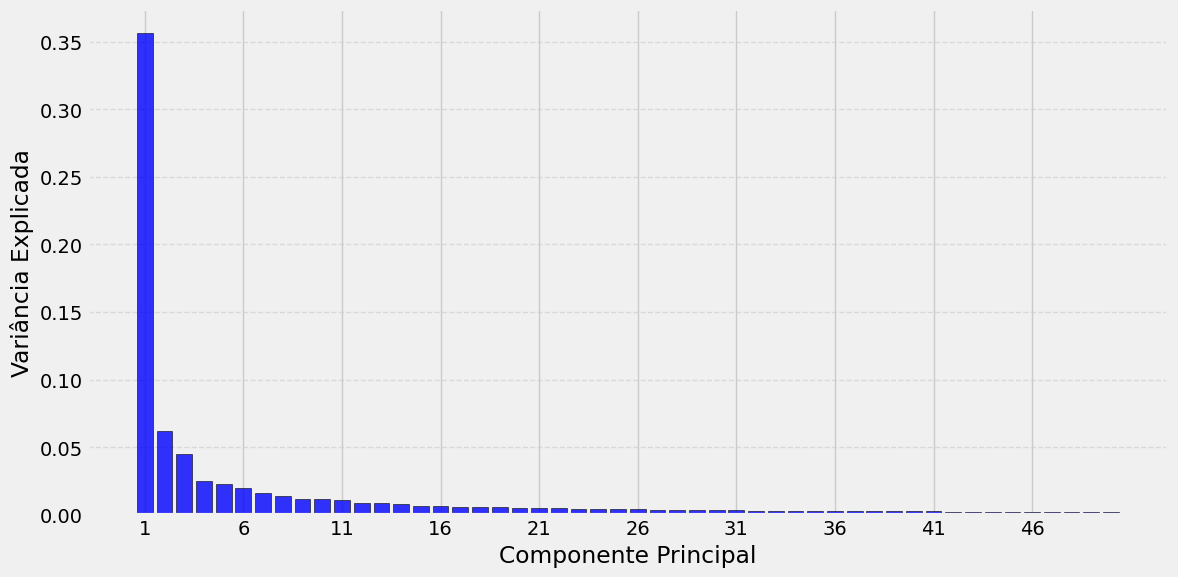

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, 51), explained_variance, alpha=0.8, color='blue', edgecolor='k')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.xticks(range(1, 51, 5))  # Exibir ticks a cada 5 componentes
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
total_explained_variance = np.sum(explained_variance)
print(f"Soma da variância explicada pelas 50 componentes principais: {total_explained_variance:.4f}")

Soma da variância explicada pelas 50 componentes principais: 0.7417


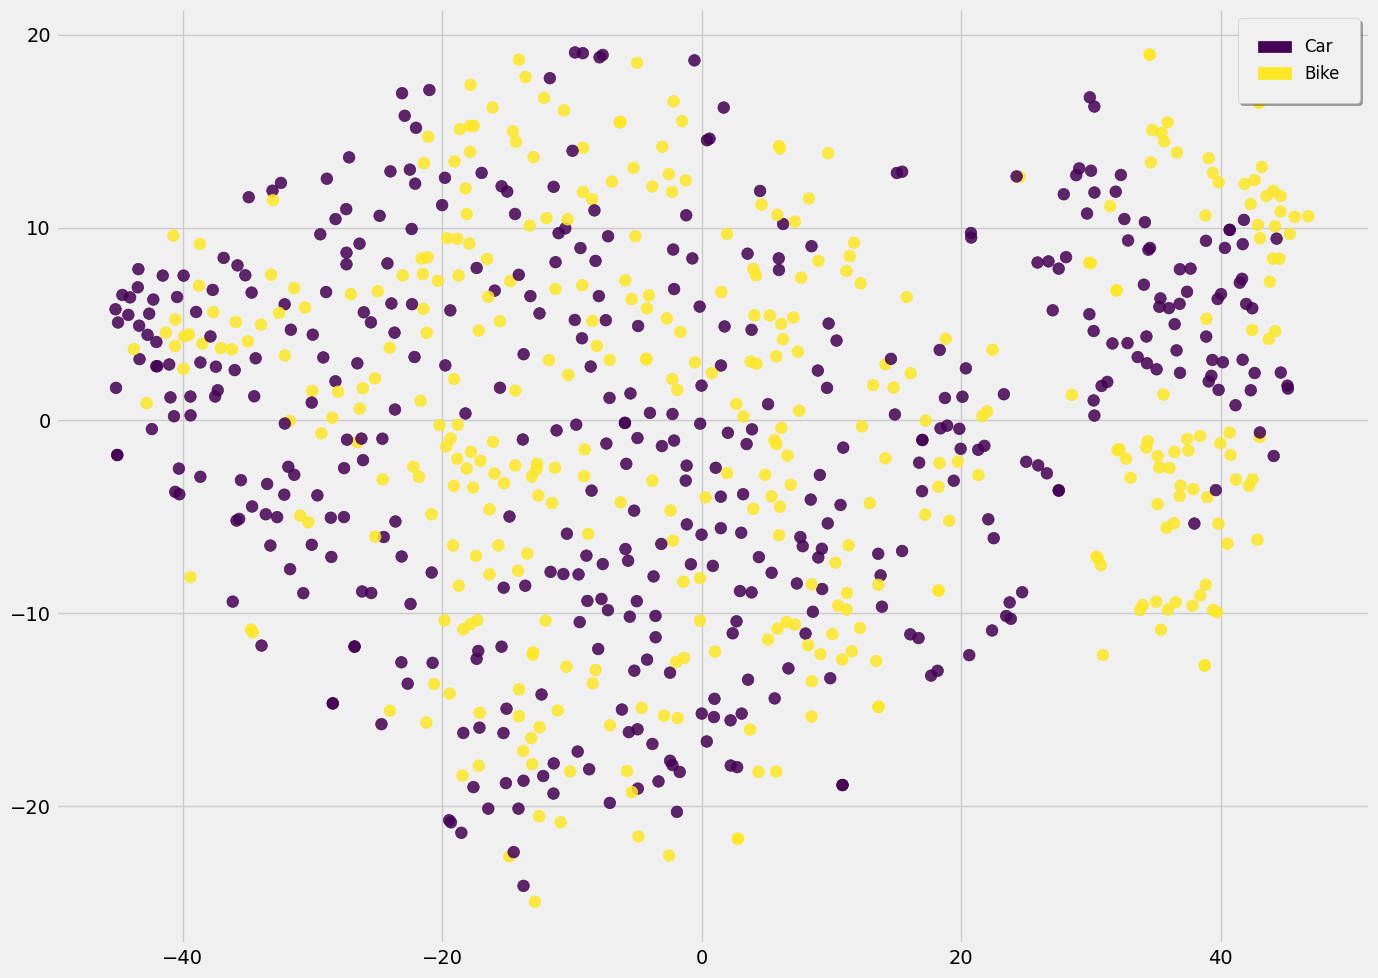

In [ ]:
plot_tsne(tsne_features_original, labels)

In [ ]:
model_feature_extraction.eval()

import numpy as np

def extract_features(model, dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for images, target in dataloader:
            images = images.to(device)

            output = model(images)
            output = output.view(output.size(0), -1)

            # output.shape [32, 8192] que é a saída após o maxpool [512, 4, 4]

            features.append(output.cpu().numpy())
            labels.append(target.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    return features, labels

features, labels = extract_features(model_feature_extraction, test_loader)

In [ ]:
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(features)

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(reduced_features)

In [ ]:
explained_variance = pca.explained_variance_ratio_

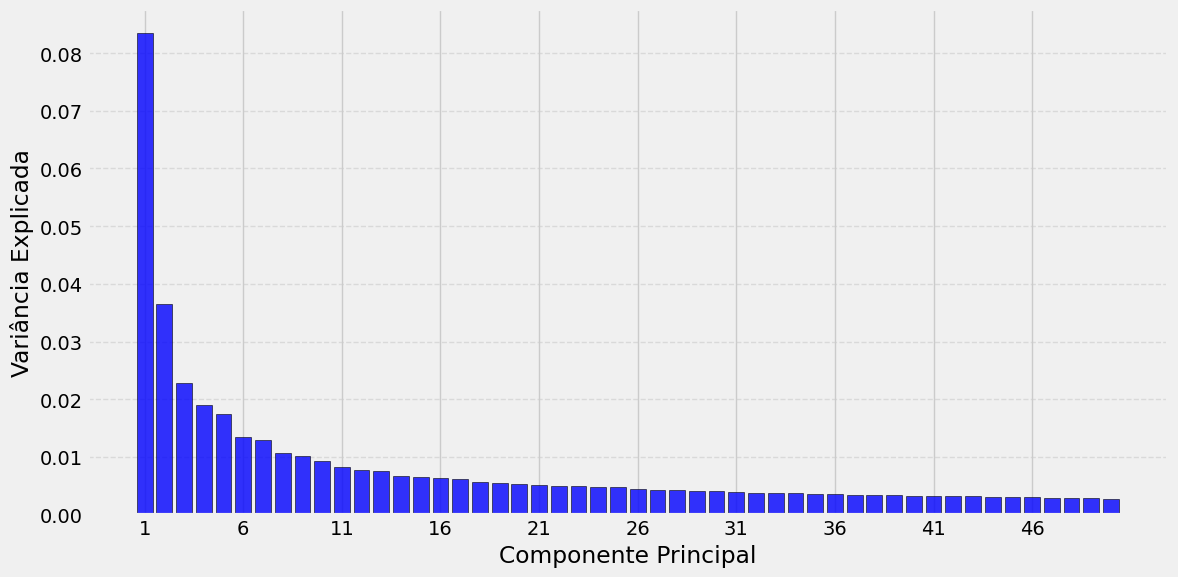

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, 51), explained_variance, alpha=0.8, color='blue', edgecolor='k')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.xticks(range(1, 51, 5))  # Exibir ticks a cada 5 componentes
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
total_explained_variance = np.sum(explained_variance)
print(f"Soma da variância explicada pelas 50 componentes principais: {total_explained_variance:.4f}")

Soma da variância explicada pelas 50 componentes principais: 0.4128


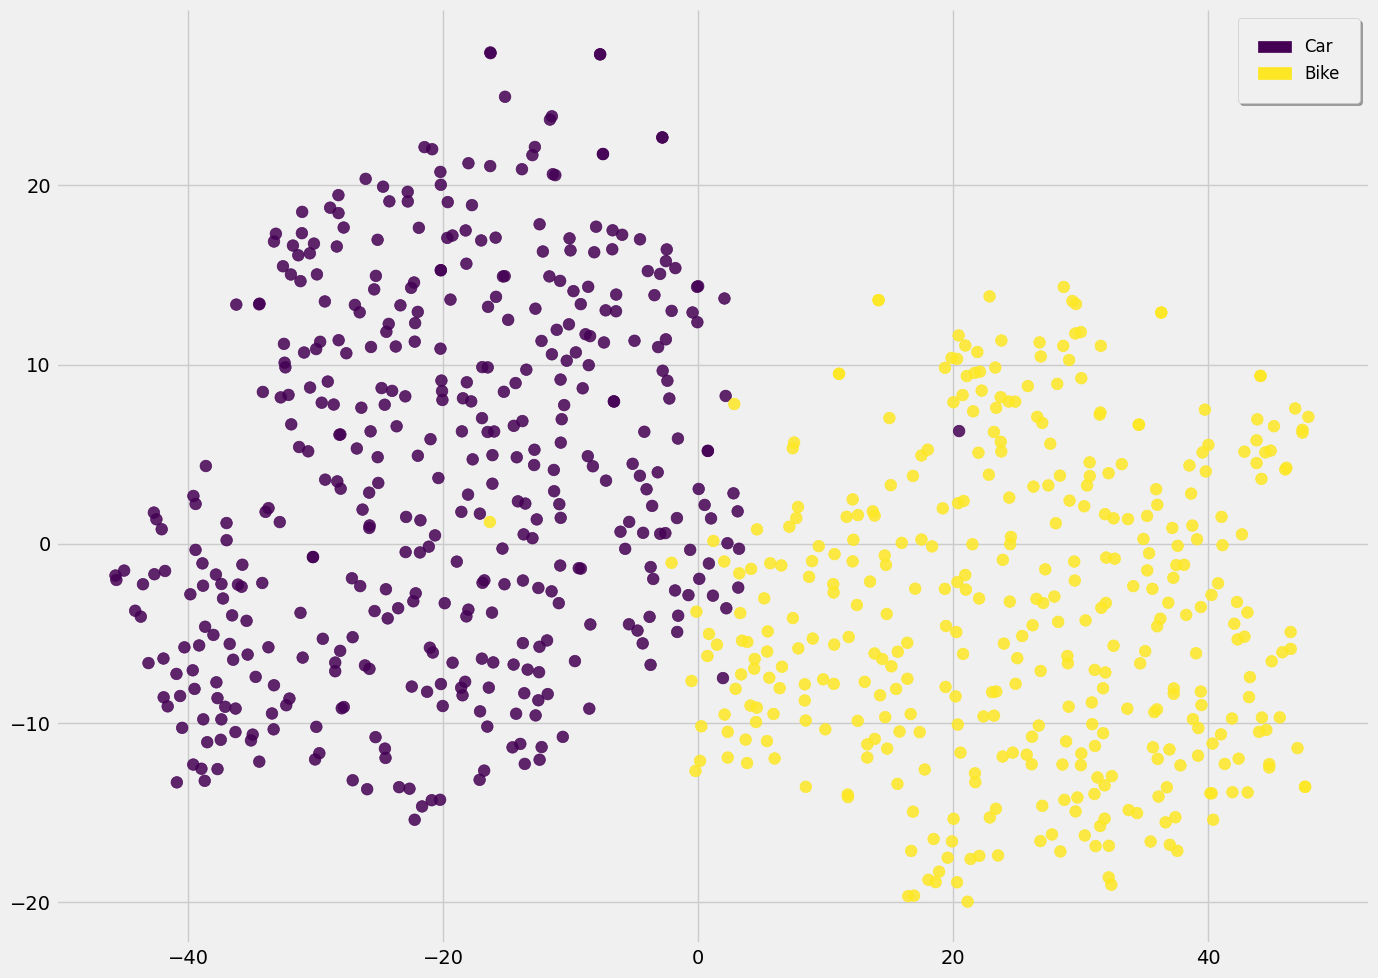

In [ ]:
plot_tsne(tsne_features, labels)